In [1]:
!pip install -q colour-science

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import csv
import colour
from scipy.optimize import differential_evolution

In [3]:
root_directory = "/content/drive/MyDrive/Mi_FFI/CalibracionBienOrganizado"

In [4]:
# Define the path of the images folder
folder_img_carne = root_directory+"/pocas_imagenes"
folder_img_paleta = root_directory+"/nuevas_paletas"

# Set the target folder for the calibrated images
folder_img_cal = root_directory+"/imagenes_calibradas"
folder_pal_cal = root_directory+"/paletas_calibradas"

if not os.path.exists(folder_img_cal):
    os.mkdir(folder_img_cal)

if not os.path.exists(folder_pal_cal):
    os.mkdir(folder_pal_cal)

In [5]:
def find_circles(paleta):
    """
    Finds circles in the given palette image
    Returns the (x,y) coordinates and the radius of each circle
    """
    gray = cv2.cvtColor(paleta, cv2.COLOR_RGB2GRAY)
    detected_circles = cv2.HoughCircles(gray, 
                        cv2.HOUGH_GRADIENT, 1, 20, param1 = 100,
                    param2 = 25, minRadius = 1, maxRadius = 25)

    if detected_circles is not None:
        detected_circles = np.uint16(np.around(detected_circles))

    return detected_circles[0]

def getColorsMatrix(paleta,detected_circles):
    """
    Gets the median of the color of each circle
    Returns median RGB values for each circle in the image
    """
    my_circles = deepcopy(detected_circles)
    circles_column_idx = np.argsort(my_circles[:,0])
    circ_sorted_x = deepcopy(my_circles[circles_column_idx,:])

    circ_split = np.array_split(circ_sorted_x,4)

    circ_sorted_y = np.zeros_like(circ_split)
    for k in range(len(circ_split)):
        circles_row_idx = np.argsort(circ_split[k][:,1])
        circ_sorted_y[k] = deepcopy(circ_split[k][circles_row_idx,:])
    
    rows,cols,_ = circ_sorted_y.shape
    my_circles = np.reshape(circ_sorted_y,(rows*cols,_))

    median_array = np.zeros((len(my_circles),3))
    for k in range(len(my_circles)):
        (x,y,r) = my_circles[k]
        
        median_r = np.median(paleta[y-(r//2):y+(r//2),x-(r//2):x+(r//2),0])
        median_g = np.median(paleta[y-(r//2):y+(r//2),x-(r//2):x+(r//2),1])
        median_b = np.median(paleta[y-(r//2):y+(r//2),x-(r//2):x+(r//2),2])
        
        median_array[k] = (median_r,median_g,median_b)
    
    return my_circles,median_array

In [6]:
def error(ind,median_p,median_cal):
    """
    Gets the error between the transformed sample palette and the calibration palette
    Returns the individual fitness
    """
    ind = np.reshape(ind,(3,3))
    return np.sum(np.abs(median_cal-np.dot(median_p,ind)))

In [7]:
# List all the meat images
files = os.listdir(folder_img_carne)
files[:5]

['20210906_S01_1_c.JPG',
 '20210906_S01_2_c.JPG',
 '20210906_S01_3_c.JPG',
 '20210906_S01_4_c.JPG',
 '20210906_S01_5_c.JPG']

In [8]:
# Show the available methods and ours
methods = sorted(colour.COLOUR_CORRECTION_METHODS.keys())
print(methods)
methods.append("Differential Evolution")
print(methods)

['Cheung 2004', 'Finlayson 2015', 'Vandermonde']
['Cheung 2004', 'Finlayson 2015', 'Vandermonde', 'Differential Evolution']


## NOTA: la paleta de calibración debe de estar en la misma carpeta que las paletas de muestra

In [9]:
# Read the calibration palette
paleta_calibracion = cv2.imread(folder_img_paleta+"/CALIBRACION.JPG")
paleta_calibracion = cv2.cvtColor(paleta_calibracion,cv2.COLOR_BGR2RGB)
# Detect the circles in the calibration palette
detected_circles = find_circles(paleta_calibracion)
# Get the median of each color in the calibration palette
circles_cal,median_cal = getColorsMatrix(paleta_calibracion,detected_circles)
median_cal = median_cal.astype("float")
median_cal

array([[ 188. ,  190. ,  203. ],
       [ 148. ,  151. ,  171. ],
       [ 122. ,  121.5,  137. ],
       [  97. ,   95. ,  109. ],
       [  72. ,   71. ,   83.5],
       [  57. ,   55. ,   65.5],
       [ 158. ,   96. ,   96. ],
       [ 146. ,   86. ,   91. ],
       [ 129. ,   73. ,   80.5],
       [ 120. ,   72. ,   77. ],
       [ 114. ,   68. ,   80. ],
       [ 106. ,   71. ,   75. ],
       [ 159. ,  107. ,   71. ],
       [  73. ,   84. ,  155. ],
       [ 157. ,   87. ,  106. ],
       [  86. ,   69. ,  107. ],
       [ 112. ,  149. ,   79. ],
       [ 167. ,  140. ,   71. ],
       [ 177. ,   76. ,   87. ],
       [  77. ,  151. ,   94. ],
       [  72. ,   85. ,  157. ],
       [ 170. ,  166. ,   71. ],
       [ 157. ,   85. ,  136. ],
       [  64. ,  111. ,  160. ]])

In [10]:
# Select the method we are going to use
for method in methods:
    print("Method:",method)
    # Create the folders to store the calibrated images
    if not os.path.exists(folder_pal_cal+'/'+method):
        os.mkdir(folder_pal_cal+'/'+method)
    if not os.path.exists(folder_img_cal+'/'+method):
        os.mkdir(folder_img_cal+'/'+method)
    # Browse the files
    for file in files:
        # print("test image...")
        # Read one meat image
        img = cv2.imread(folder_img_carne+f"/{file}")
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        # Read the corresponding palette image
        img_paleta = cv2.imread(folder_img_paleta+f"/{file}")
        img_paleta = cv2.cvtColor(img_paleta,cv2.COLOR_BGR2RGB)
        # print("detect circles...")
        # Detect the circles in the palette
        detected_circles = find_circles(img_paleta)
        # print("get medians...")
        # Get the median of each color in the palette
        circles_p,median_p = getColorsMatrix(img_paleta,detected_circles)

        # The medians must be as a float
        median_p = median_p.astype("float")
        
        # print("vectorize cal img...")
        img_copy=img.copy()
        rows,cols,ch = img_copy.shape
        # Create a vector of the image
        vec_img = np.reshape(img_copy,(rows*cols,ch)).astype("float")
        
        # print("vectorize palette...")
        # Also, calibrate the corresponding palette
        paleta_copy=img_paleta.copy()
        prows,pcols,pch = paleta_copy.shape
        vec_paleta = np.reshape(paleta_copy,(prows*pcols,pch))

        if method == "Differential Evolution":
            # print("differential evolution...")
            # Set the bounds for the Differential Evolution Algorithm
            bounds = [[-100,100]]*9
            res = differential_evolution(error,bounds,args=(median_p,median_cal))
            mat_transform = np.reshape(res.x,(3,3))
            # Get the vector of the calibrated image
            vec_cal_img = np.dot(vec_img,mat_transform)
            vec_cal_paleta = np.dot(vec_paleta,mat_transform)
        else:
            vec_cal_img = colour.colour_correction(vec_img,median_p,median_cal,method=method)
            vec_cal_paleta = colour.colour_correction(vec_paleta,median_p,median_cal,method=method)
        
        # print("2d cal img...")
        # Make sure the values are in the RGB range
        vec_cal_img[vec_cal_img > 255] = 255
        vec_cal_img[vec_cal_img < 0] = 0
        # Reshape the vectorized image to a 2D image
        cal_img = np.uint8(np.reshape(vec_cal_img,(rows,cols,ch)))

        vec_cal_paleta[vec_cal_paleta > 255],vec_cal_paleta[vec_cal_paleta < 0] = 255,0
        # print("2d palette...")
        cal_paleta = np.uint8(np.reshape(vec_cal_paleta,(prows,pcols,pch)))

        # print("write images...")
        cv2.imwrite(f"{folder_img_cal}/{method}/{file}",cv2.cvtColor(cal_img,cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{folder_pal_cal}/{method}/{file}",cv2.cvtColor(cal_paleta,cv2.COLOR_RGB2BGR))

Method: Cheung 2004


## Errores de calibración

In [11]:
carnes = {
    "arrachera":[file for file in files if file.split('_')[1]=="A01"],
    "sirloin":[file for file in files if file.split('_')[1]=="S01"],
    "bola":[file for file in files if file.split('_')[1]=="B01"]
}

sirloin


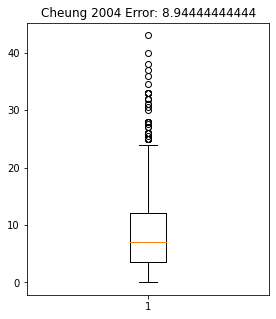

In [12]:
if not os.path.exists(root_directory+"/ErroresCalibracion"):
    os.mkdir(root_directory+"/ErroresCalibracion")

for tipo_carne,archivos in carnes.items():
    if len(archivos)==0:
        continue
    print(tipo_carne)
    if os.path.exists(root_directory+"/ErroresCalibracion/"+tipo_carne+".csv"):
        os.remove(root_directory+"/ErroresCalibracion/"+tipo_carne+".csv")
    folders = [foldername for foldername in os.listdir(folder_pal_cal) if os.path.isdir(folder_pal_cal+'/'+foldername)]
    errores_metodos = [None]*len(folders)
    for j,foldername in enumerate(folders):
        diff_median = np.zeros((len(archivos),24,3),dtype=float) # Differences between each sample image and the calibration image
        for k,filename in enumerate(archivos):
            img_paleta = cv2.imread(folder_pal_cal+'/'+foldername+'/'+filename,cv2.IMREAD_COLOR)
            img_paleta = cv2.cvtColor(img_paleta,cv2.COLOR_BGR2RGB)

            detected_circles = find_circles(img_paleta)
            if len(detected_circles) != 24:
                print("There are not 24 circles in the image")
                print(file)
                break

            circles_p,median_p = getColorsMatrix(img_paleta,detected_circles)

            diff_median[k] = np.abs(median_cal-median_p)
            
        errores_metodos[j] = diff_median.flatten()
        with open(root_directory+"/ErroresCalibracion/"+tipo_carne+".csv","a") as file:
            file.write(foldername+",")
            file.write(",".join(errores_metodos[j].astype("str")))
            file.write("\n")
    
    plt.figure(figsize=(20,5))
    for j in range(len(errores_metodos)):
        plt.subplot(1,4,j+1)
        plt.title(folders[j]+" Error: "+str(np.average(errores_metodos[j])))
        plt.boxplot(errores_metodos[j])
    plt.show()

    

In [13]:
from scipy.stats import f_oneway

In [14]:
errores = [None]*len(folders)
for filename in os.listdir(root_directory+"/ErroresCalibracion"):    
    print(filename)
    with open(root_directory+"/ErroresCalibracion/"+filename, 'r') as file:
        reader = csv.reader(file)
        rows = list(reader)
        for i,row in enumerate(rows):
            errores[i] = np.array(row[1:],dtype=float)
        result = f_oneway(*errores)
        print(result)    
    


sirloin.csv
F_onewayResult(statistic=nan, pvalue=nan)


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3347: RuntimeWarning: invalid value encountered in double_scalars
  msb = ssbn / dfbn
